In [1]:
# Gerekli kütüphaneleri içe aktaralım
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import time
import warnings
warnings.filterwarnings('ignore')
import cv2
import os

# GPU kullanılabilirliğini kontrol edelim
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")


2025-09-22 22:31:09.807085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758580269.978525      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758580270.029383      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


In [2]:
#Hyperparametreler ve Config

IMG_SIZE = (48, 48)
BATCH_SIZE = 64
NUM_CLASSES = 7
TRAIN_DIR = '/kaggle/input/fer2013/train'
TEST_DIR = '/kaggle/input/fer2013/test'

**Train verisini yüklüyoruz ve %20'lik kısmı validation için ayırıyoruz , çeşitli yöntemlerle data augmentation uyguluyoruz(döndürme,resize,zoom gibi)**

**Validation setinin kötü etkilenmemesi için validation setine augmentation uygulamadık**

**Aynı zamanda görüntülerin piksel değerlerini 0-255 aralığından 0-1 aralığına indirerek normalize ettik**



In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Dataset'in dağılımına bakalım**

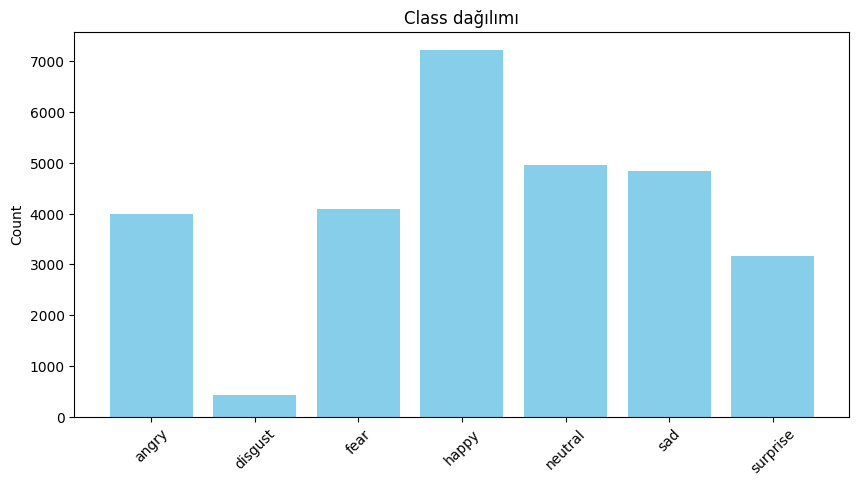

In [4]:
classes = sorted(os.listdir(TRAIN_DIR))
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]

plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts, color='skyblue')
plt.title('Class dağılımı')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Şimdi elimizdeki dataseti anlamak amacıyla classlardaki resimleri biraz inceleyelim.**

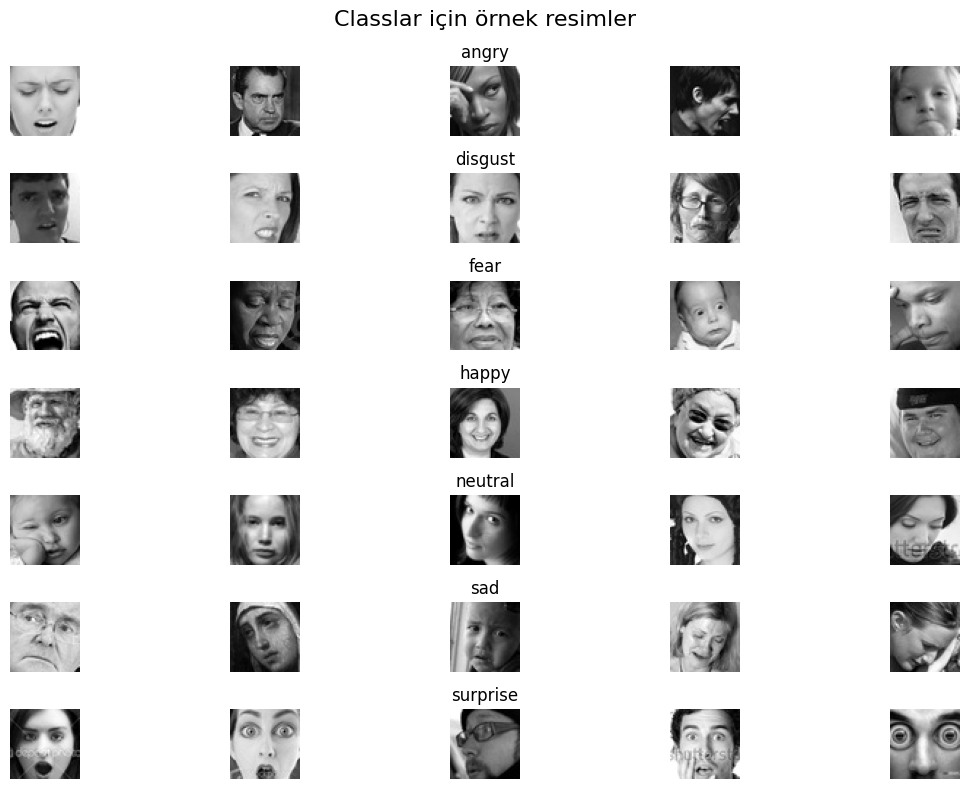

In [5]:

IMG_SIZE = (48, 48)

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    cls_path = os.path.join(TRAIN_DIR, cls)
    sample_imgs = os.listdir(cls_path)[:5]  

    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(cls_path, img_name)
        img = load_img(img_path, color_mode='grayscale', target_size=IMG_SIZE)
        plt_idx = i * 5 + j + 1
        plt.subplot(len(classes), 5, plt_idx)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if j == 2:
            plt.title(cls)

plt.suptitle('Classlar için örnek resimler', fontsize=16)
plt.tight_layout()
plt.show()


**MODEL**

In [6]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1758580316.612684      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,470,951 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

**Callbackleri ayarlıyoruz, öğrenme oranını dinamik bir şekilde küçültme stratejisi uyguladık**

In [7]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

**Modeli eğitiyoruz**

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50


I0000 00:00:1758580325.972010      84 service.cc:148] XLA service 0x7ce4f400a540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758580325.973053      84 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758580326.703647      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/359 ━━━━━━━━━━━━━━━━━━━━ 1:22:50 14s/step - accuracy: 0.2031 - loss: 2.8952

I0000 00:00:1758580332.738856      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 187s 484ms/step - accuracy: 0.2006 - loss: 2.4177 - val_accuracy: 0.1765 - val_loss: 2.0038 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.2645 - loss: 1.8523 - val_accuracy: 0.3902 - val_loss: 1.5828 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.3415 - loss: 1.6744 - val_accuracy: 0.3933 - val_loss: 1.5746 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.4082 - loss: 1.5236 - val_accuracy: 0.4363 - val_loss: 1.5197 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.4514 - loss: 1.4281 - val_accuracy: 0.4126 - val_loss: 1.7290 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.4773 - loss: 1.3640 - val_accuracy: 0.3090 - val_loss: 2.1800 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.4991 - loss: 1.3

**Accuracy ve Loss Grafikleri**

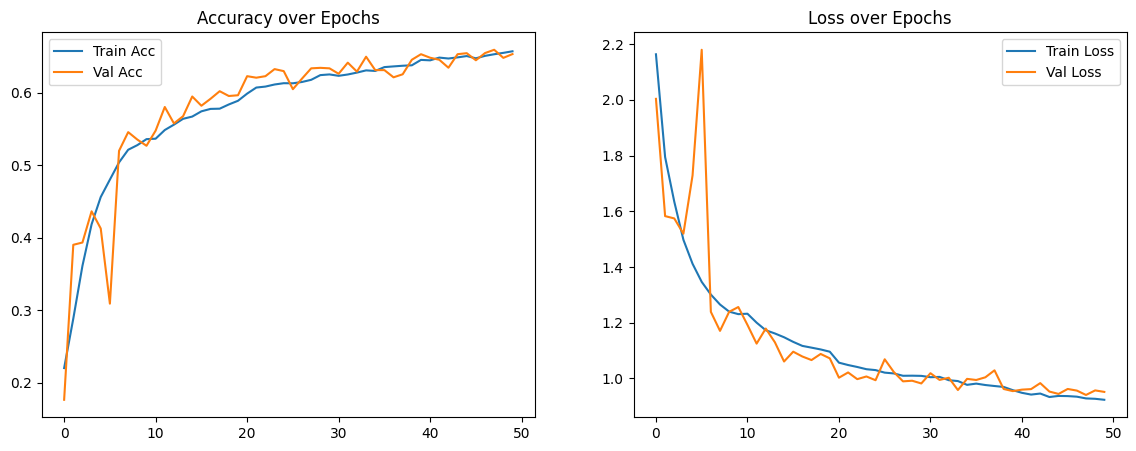

In [9]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()

plt.show()


**Grafikleri analiz edelim:** Train accuracy ve Validation accuracy değerleri birbirine yakın seyretmiş, bu modelimizin overfit veya underfit olamdığını gösteriyor, accuracy değerimiz %65 civarlarında, bu da iyiye işaret ediyor, gelişime açık.

**Test başarı metrikleri:**

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.6076 - loss: 1.0505
Test Accuracy: 65.28%
Test Loss: 0.9467


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step


<Figure size 800x800 with 0 Axes>

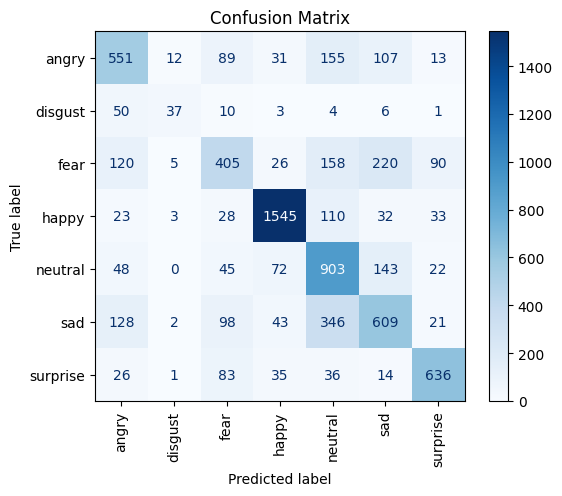

In [11]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))

plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


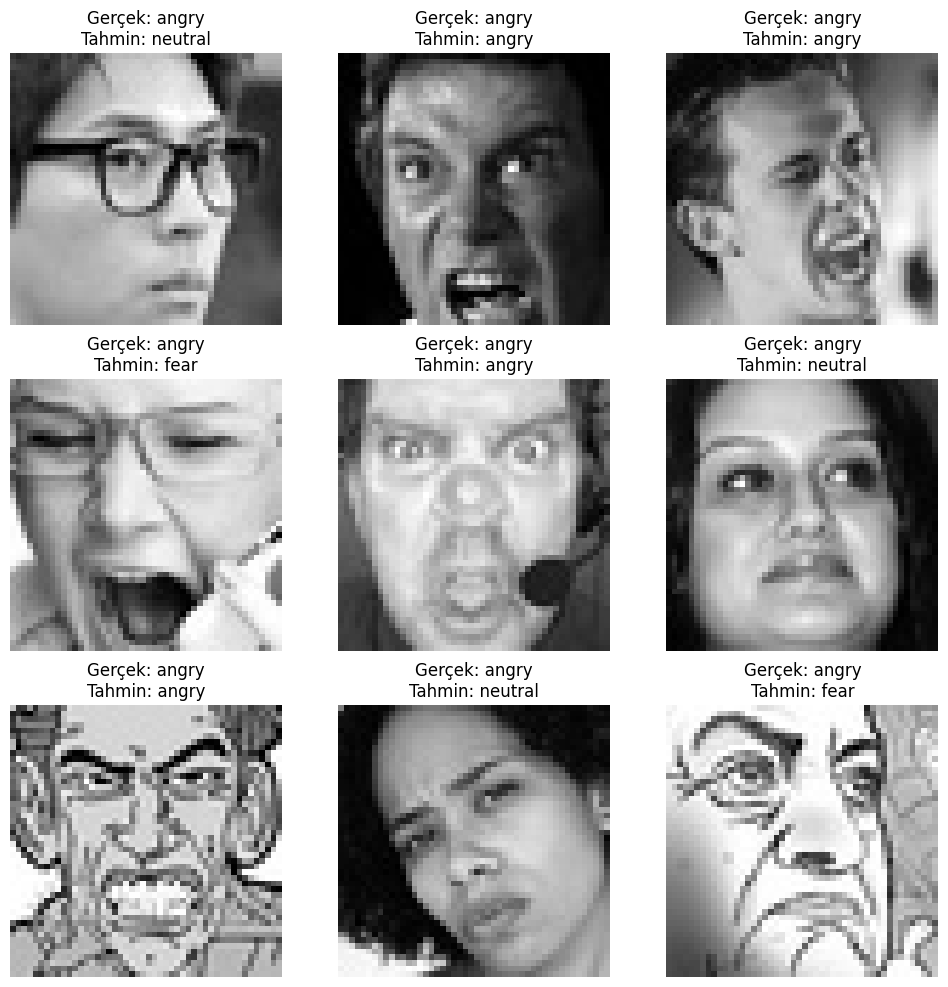

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random

classes = list(test_generator.class_indices.keys())

images, labels = next(test_generator)
true_labels = np.argmax(labels, axis=1)
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Batch'ten rastgele 9 indeks seçiyoruz
num_to_show = min(9, len(images))
random_indices = random.sample(range(len(images)), num_to_show)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[idx].reshape(48,48), cmap='gray')
    plt.title(f"Gerçek: {classes[true_labels[idx]]}\nTahmin: {classes[pred_labels[idx]]}")
    plt.axis('off')

plt.show()


**Batch'in içinden rastgele 9 resim ve modelin tahminleri**